In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

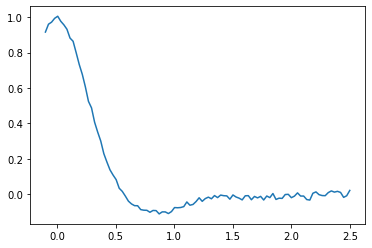

In [11]:
matlab_data = np.genfromtxt('trace_matlab_ln.dat', delimiter=',')

sigma_model = 0.01

t = matlab_data[:,0]
S = matlab_data[:,1]

plt.plot(t,S);

In [7]:
r = np.linspace(2,8,len(t))

In [8]:
K = dl.dipolarkernel(t,r,integralop=True)    # kernel matrix
K[:,0] = 2*K[:,0]
K[:,-1] = 2*K[:,-1]

In [9]:
KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)

In [10]:
a0 = 0.01
b0 = 1e-6

In [12]:
testdata, testpars = dive.generateMultiGauss(nr = len(t), nt = len(t), seed = 129)

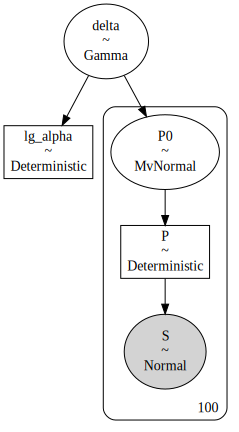

In [13]:
with pm.Model() as model:
    # Noise
    # sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    sigma = sigma_model
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu = testdata['P'], chol = C_L, shape = len(r)) 

    P = pm.Deterministic("P",P0)
    # P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    # V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [14]:
with model:
    step_P0 = dive.SampleEdwardsModel(P0, delta, sigma, KtK, KtS, LtL, len(r))  
    trace = pm.sample(step = step_P0, chains=4, cores=2, draws=5000, tune=2000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>SampleEdwardsModel: [P0]
>NUTS: [delta]
Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 1237 seconds.
The acceptance probability does not match the target. It is 0.6199449393054102, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
δ,19061.741,5018.248,10158.136,28405.240,58.779,41.565,6697.0,8771.0,1.0
lg(α),0.133,0.057,0.024,0.238,0.001,0.001,6697.0,8771.0,1.0


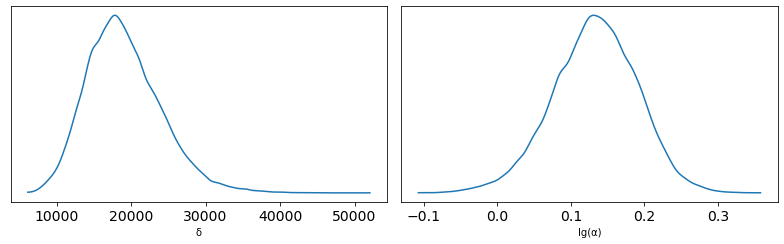

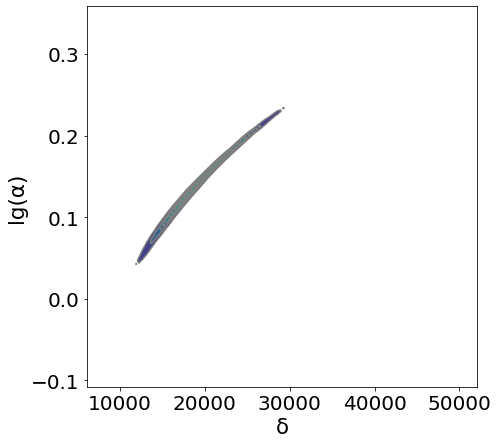

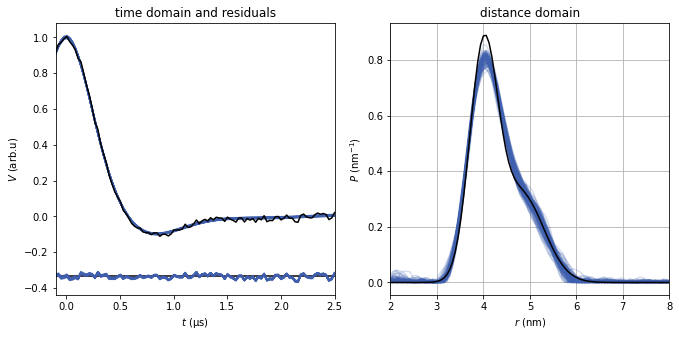

In [15]:
dive.summary(trace, model, S, t, r, Pref = testdata['P'])

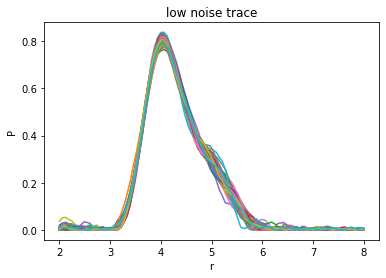

In [16]:
for i in np.linspace(-1,-501,50):
    plt.plot(r,trace['P'][int(i)])

plt.xlabel('r')
plt.ylabel('P')
plt.title('low noise trace');

## high noise

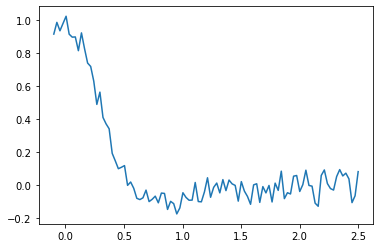

In [20]:
matlab_data = np.genfromtxt('trace_matlab_hn.dat', delimiter=',')

sigma_model = 0.05

t = matlab_data[:,0]
S = matlab_data[:,1]

plt.plot(t,S);

In [18]:
r = np.linspace(2,8,len(t))

K = dl.dipolarkernel(t,r,integralop=True)    # kernel matrix
K[:,0] = 2*K[:,0]
K[:,-1] = 2*K[:,-1]

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)

In [19]:
a0 = 0.01
b0 = 1e-6

testdata, testpars = dive.generateMultiGauss(nr = len(t), nt = len(t), seed = 129)

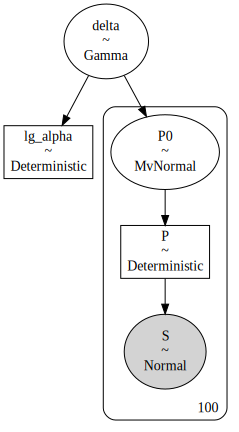

In [21]:
with pm.Model() as model:
    # Noise
    # sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    sigma = sigma_model
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu = testdata['P'], chol = C_L, shape = len(r)) 

    P = pm.Deterministic("P",P0)
    # P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Time domain
    # V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    Smodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [22]:
with model:
    step_P0 = dive.SampleEdwardsModel(P0, delta, sigma, KtK, KtS, LtL, len(r))  
    trace = pm.sample(step = step_P0, chains=4, cores=2, draws=8000, tune=4000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>SampleEdwardsModel: [P0]
>NUTS: [delta]
Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 1365 seconds.
The acceptance probability does not match the target. It is 0.6457774915046347, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
δ,5140.496,1592.879,2397.001,8124.215,25.253,17.858,3735.0,5875.0,1.0
lg(α),0.544,0.068,0.420,0.673,0.001,0.001,3735.0,5875.0,1.0


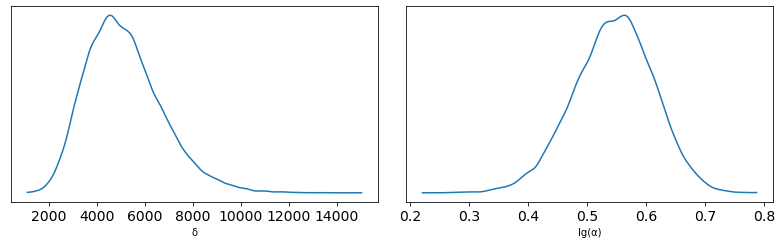

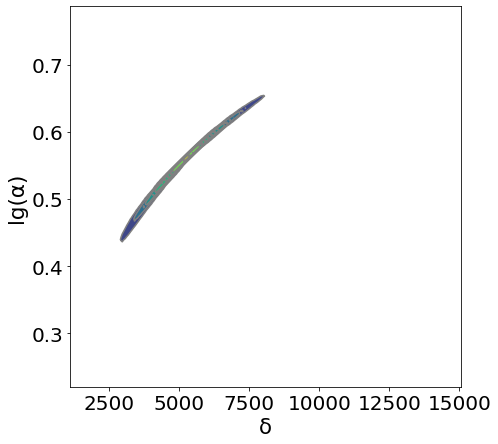

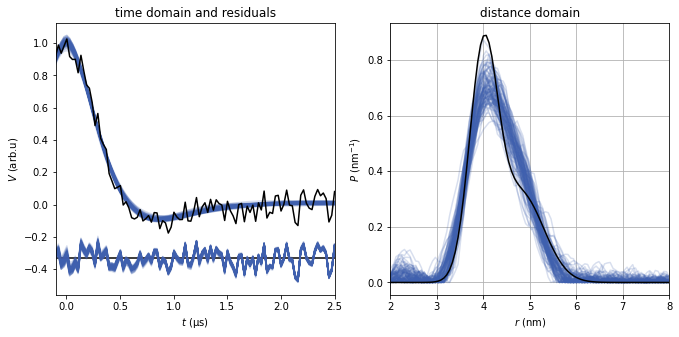

In [23]:
dive.summary(trace, model, S, t, r, Pref = testdata['P'])

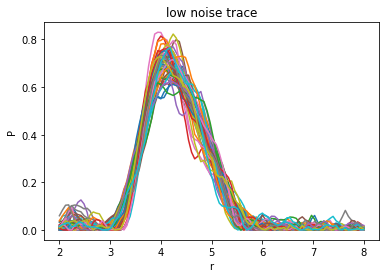

In [24]:
for i in np.linspace(-1,-501,50):
    plt.plot(r,trace['P'][int(i)])

plt.xlabel('r')
plt.ylabel('P')
plt.title('low noise trace');